In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import visualization
import datahandler

calm first: False


/home/jonathan/Desktop/Driving_Sim Stuff/driving_performance_project/datahandler.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_data['Order'] = 'PN' if calmFirst else 'NP'
/home/jonathan/Desktop/Driving_Sim Stuff/driving_performance_project/datahandler.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_data['DrivingPerformance'] = normalized_distance * normalized_speed


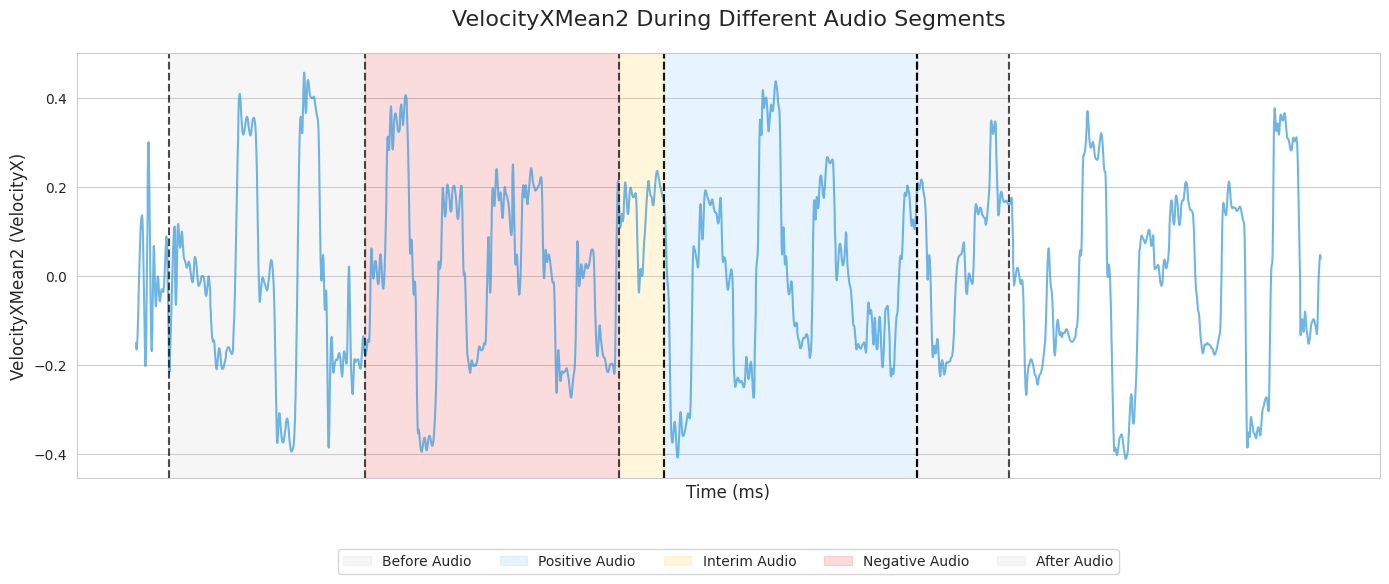

In [2]:
participant_code = 'G9K4W1Z0' 
load_state_data = False
data_path = './participant data/'
trimmed_data, sections, gender, age, calmFirst = datahandler.load_participant(participant_code, data_path, load_state_data)

trimmed_data['VelocityXMean2'] = trimmed_data['VelocityX'].rolling(window=10000, min_periods=1000).mean()
print(f'calm first: {calmFirst}')
visualization.plot_column(trimmed_data, 'VelocityXMean2', 'VelocityX', sections=sections)

In [12]:
speed_sign_data = trimmed_data[trimmed_data['DistanceToNextOverheadSign'] == 0]
speed_sign_data = speed_sign_data.drop_duplicates(subset=['Timestamp'])

seconds = 10
#drop rows around speed signs that are too close in time
results = []
last_event_time = None
for idx, row in speed_sign_data.iterrows():
    current_time = row['Timestamp']
    if last_event_time is None or current_time - last_event_time >= seconds * 1000:
        results.append(row)
        last_event_time = current_time

speed_sign_data = pd.DataFrame(results)
#subplot for all speed signs
# fig, axs = plt.subplots(len(speed_sign_data) // 10, 10 , figsize=(10,10))
#select rows in a time window of 10 seconds before and after the speed sign


windows = pd.DataFrame(columns=speed_sign_data.columns)
print(windows)
for i in range(len(speed_sign_data)):

    timestamp = speed_sign_data.iloc[i]['Timestamp']
    start_time = timestamp - seconds * 1000
    end_time = timestamp + seconds * 1000
    
    # Select the rows within the time window
    time_window_data = trimmed_data[(trimmed_data['Timestamp'] >= start_time) & (trimmed_data['Timestamp'] <= end_time)]
    # print(time_window_data)
    # axs[i // 10, i % 10].plot(time_window_data['Timestamp'], time_window_data['VelocityX'], label=f'Speed Sign {i+1}')
    # axs[i // 10, i % 10].set_axis_off()
    windows = pd.concat([windows, time_window_data], ignore_index=True)


windows = windows.sort_values(by='Timestamp')

Empty DataFrame
Columns: [Timestamp, Channel 13 (ECG100C), Channel 9 (EDA100C), MarkerName, MarkerDescription, MarkerType, DistanceToNextSpeedSign, DistanceToNextOverheadSign, VelocityX, DistanceToTargetPosition, DistanceToTargetSpeed, CarSpeed, ET_PupilLeft, ET_PupilRight, Order, DrivingPerformance, VelocityXMean2]
Index: []


/tmp/ipykernel_28084/3627879028.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  windows = pd.concat([windows, time_window_data], ignore_index=True)


In [15]:
windows

,Timestamp,Channel 13 (ECG100C),Channel 9 (EDA100C),MarkerName,MarkerDescription,MarkerType,DistanceToNextSpeedSign,DistanceToNextOverheadSign,VelocityX,DistanceToTargetPosition,DistanceToTargetSpeed,CarSpeed,ET_PupilLeft,ET_PupilRight,Order,DrivingPerformance,VelocityXMean2
0,1.940720e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NP,NaN,NaN
1,2.034480e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,NP,NaN,NaN
2,2.034730e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,NP,NaN,NaN
3,2.034950e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,NP,NaN,NaN
4,2.035160e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,NP,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577155,1.265915e+06,0.196533,3.901978,Experiment,Calm audio has stopped playing.,E,483.0,419.0,-0.337334,0.855268,3.822556,133.8226,5.0,5.0,NP,0.824159,-0.110800
577156,1.265920e+06,0.097961,3.901978,Experiment,Calm audio has stopped playing.,E,483.0,419.0,-0.337334,0.855268,3.822556,133.8226,5.0,5.0,NP,0.824159,-0.110821
577157,1.265925e+06,-0.074463,3.902283,Experiment,Calm audio has stopped playing.,E,483.0,419.0,-0.337334,0.855268,3.822556,133.8226,5.0,5.0,NP,0.824159,-0.110842
577158,1.265927e+06,-0.074463,3.902283,Experiment,Calm audio has stopped playing.,E,483.0,419.0,-0.344596,1.544909,3.822556,133.8226,5.0,5.0,NP,0.723468,-0.110864


In [14]:
print(len(results))
print(trimmed_data['Timestamp'].max() / 1000 / 60)
print(21/70 * 60)

70
21.19432932
18.0


In [ ]:
%matplotlib agg

_ = visualization.compare_perf_kdes(participant_code, trimmed_data, sections=sections)
%matplotlib inline

### Analyze distributions

In [ ]:
import os

def get_all_stats(remove_outliers=None, drop_gender=None, drop_order=None, save_folder=''):
    for root, dirs, files in os.walk(data_path):
        identifiers = [f.replace('.csv','') for f in files if f != "W1D9N0B8.csv" and f != 'M3A2H7Q4.csv']
    print(identifiers)

    intense_stats = []
    calm_stats = []
    for id in identifiers:
        load_state_data = False

        try:
            trimmed_data, sections, gender, age, calmFirst = datahandler.load_participant(id, data_path, load_state_data, remove_outliers=remove_outliers)
            print(f'{id} OK')
            calmFirst = "PN" if calmFirst else "NP"
            if gender == drop_gender:
                print(f'Skipping {id} cause of gender')
                continue
            if drop_order and calmFirst == drop_order:
                print(f'Skipping {id} cause of order')
                continue
        except Exception as e:
            print(f'{id} FAIL')
            # print(e)
            continue
        
        
        trimmed_data['VelocityXMean'] = trimmed_data['VelocityX'].rolling(window=10000).mean()
        trimmed_data['DistanceToTargetPositionStd'] = trimmed_data['DistanceToTargetPosition'].rolling(window=10000).std()
        trimmed_data['DistanceToTargetSpeed_Mean'] = trimmed_data['DistanceToTargetSpeed'].rolling(window=10000).mean()
        trimmed_data['VelocityX_Mean'] = trimmed_data['VelocityX'].rolling(window=10000).mean()
        
        visualization.compare_perf_kdes(id, trimmed_data, sections=sections, save_path=save_folder)

        pairs = [
        ('VelocityX', 'Lateral Velocity'),
        ('DistanceToTargetSpeed', 'Difference to Correct Speed'),
        ('DistanceToTargetPosition','Distance to Correct Lane'),
        ('CarSpeed', 'Car Speed')
        ]

        for (col1, col2) in pairs:
            mean1, std1, mom1, mean2, std2, mom2 = datahandler.get_statistics(trimmed_data, col1, col2, sections=sections)
            calm_stats.append((mean1, std1, mom1))
            intense_stats.append((mean2, std2, mom2))
    return calm_stats, intense_stats

In [ ]:
%matplotlib agg
calm_stats, intense_stats = get_all_stats(save_folder='perf_plots/all/')
%matplotlib inline

['C1K4L9S8', 'D0P7X9W6', 'G2Y7J4Q1', 'G9K4W1Z0', 'I8L4N6G7', 'J4X1T0D2', 'J6W7Q4H5', 'K4G7Y9O2', 'L0S1Z2I3', 'L1N3B5O2', 'M0R6U5F9', 'M4H6R2W9', 'M7D3F5K4', 'N7P5B8G0', 'O4A0U8R1', 'U6O5V2T9', 'V9L0P2K7', 'X5Q0G4J2', 'Z6A2W1E8']
C1K4L9S8 OK
D0P7X9W6 OK
G2Y7J4Q1 OK
G9K4W1Z0 OK
I8L4N6G7 OK
J4X1T0D2 OK
J6W7Q4H5 OK
K4G7Y9O2 OK
L0S1Z2I3 OK
L1N3B5O2 OK
M0R6U5F9 OK
M4H6R2W9 OK
M7D3F5K4 OK
N7P5B8G0 OK
O4A0U8R1 OK
U6O5V2T9 OK
V9L0P2K7 OK
X5Q0G4J2 OK
Constructing timestamps from scratch
Saved reconstructed markers to CSV
Z6A2W1E8 OK


c:\Users\JonathanKubik\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\_lib\_util.py:1023: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return fun(*args, **kwargs)


In [ ]:
def generate_datasets(calm_stats, intense_stats, pairs):
    N = len(pairs)      
    velocity_x_intense = [intense_stats[i] for i in range(len(intense_stats)) if i % N == 0]
    speed_intense = [intense_stats[i] for i in range(len(intense_stats)) if i % N == 1]
    position_intense = [intense_stats[i] for i in range(len(intense_stats)) if i % N == 2]
    speed_intense = [intense_stats[i] for i in range(len(intense_stats)) if i % N == 3]
    velocity_x_calm = [calm_stats[i] for i in range(len(calm_stats)) if i % N == 0]
    speed_calm = [calm_stats[i] for i in range(len(calm_stats)) if i % N == 1]
    position_calm = [calm_stats[i] for i in range(len(calm_stats)) if i % N == 2]
    speed_calm = [calm_stats[i] for i in range(len(calm_stats)) if i % N == 3]
    datasets = [[velocity_x_intense, velocity_x_calm],
                    [speed_intense, speed_calm],
                    [position_intense, position_calm],
                    [speed_intense, speed_calm]]
    return datasets


In [ ]:
pairs = [
    ('VelocityX', 'Lateral Velocity'),
    ('DistanceToTargetSpeed', 'Difference to Correct Speed'),
    ('DistanceToTargetPosition', 'Distance to Correct Lane'),
    ('CarSpeed', 'Car Speed')]

datasets = generate_datasets(calm_stats=calm_stats, intense_stats=intense_stats, pairs=pairs)
titles = ['Lateral Velocity', 'Difference to Correct Speed', 'Distance to Correct Lane', 'Car Speed']   

def plot_all_perf_param_kdes(datasets=datasets, titles=titles):
    for j, (intense, calm) in enumerate(datasets):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        for i in range(3):
            sns.kdeplot([x[i] for x in intense], label=f'Intense', ax=axes[i])
            sns.kdeplot([x[i] for x in calm], label=f'Calm', ax=axes[i])
            axes[i].set_title(f'{['Means', 'Std', 'Mom^3'][i]}')
        plt.suptitle(f'KDE of {titles[j]}')
        plt.tight_layout()
        plt.savefig('kde_lateral_velocity_statistics.png', dpi=300)
        plt.legend()
        plt.show()

plot_all_perf_param_kdes(datasets=datasets, titles=titles)

In [ ]:
import scipy.stats as stats
from scipy.stats import ttest_rel
from scipy.stats import kruskal

def print_statistical_tests(datasets, titles):
    for j, (intense, calm) in enumerate(datasets):
        print(f'\nT-test results for {titles[j]}, intense vs calm:')
        print(f'Means: {ttest_rel([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
        print(f'STDs: {ttest_rel([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
        print(f'Mom^3s: {ttest_rel([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')
        print(f'\nKruskal results for {titles[j]}, intense vs calm:')
        print(f'Means: {kruskal([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
        print(f'STDs: {kruskal([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
        print(f'Mom^3s: {kruskal([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')


In [ ]:

def plot_all_boxplot_perf(datasets=datasets, titles=titles):
    for j, (intense, calm) in enumerate(datasets):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        for i in range(3):
            sns.boxplot({'Negative':[x[i] for x in intense], 'Positive':[x[i] for x in calm]}, ax=axes[i],palette={'Negative':'tomato', 'Positive':'skyblue'} )
            sns.swarmplot({'Negative':[x[i] for x in intense], 'Positive':[x[i] for x in calm]}, ax=axes[i], color='black', alpha=0.5)
            axes[i].set_title(f'{['Means', 'Std', 'Mom^3'][i]}')
        plt.suptitle(f'Boxplot of {titles[j]}')
        plt.tight_layout()
        plt.savefig('boxplot.png', dpi=300)
        # plt.legend()
        plt.show()

In [ ]:
plot_all_boxplot_perf(datasets=datasets, titles=titles)

In [ ]:
%matplotlib agg

intense_stats_wo, calm_stats_wo = get_all_stats(remove_outliers=['VelocityX', 'DistanceToTargetPosition', 'DistanceToTargetSpeed'], save_folder='perf_plots/wo/')
dataset_wo = generate_datasets(calm_stats=calm_stats_wo, intense_stats=intense_stats_wo, pairs=pairs)

%matplotlib inline

In [ ]:
# plot_all_perf_param_kdes(datasets=dataset_wo, titles=titles)

In [ ]:

for j, (intense, calm) in enumerate(dataset_wo):
    print(f'\nT-test results for {titles[j]}, intense vs calm:')
    print(f'Means: {ttest_rel([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
    print(f'STDs: {ttest_rel([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
    print(f'Mom^3s: {ttest_rel([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')


T-test results for Lateral Velocity, intense vs calm:
Means: 0.07833641281265952
STDs: 0.6881220882944239
Mom^3s: 0.6630357232082915

T-test results for Difference to Correct Speed, intense vs calm:
Means: 0.5384138535523253
STDs: 0.2958704693933502
Mom^3s: 0.5806549845487197

T-test results for Distance to Correct Lane, intense vs calm:
Means: 0.8192949464483934
STDs: 0.9363408634181676
Mom^3s: 0.9930440847089991

T-test results for Car Speed, intense vs calm:
Means: 0.5384138535523253
STDs: 0.2958704693933502
Mom^3s: 0.5806549845487197


In [ ]:
# plot_all_boxplot_perf(datasets=dataset_wo, titles=titles)

In [ ]:
speed_intense = datasets[1][0]
speed_calm = datasets[1][1]

### Analyze Gender Dependencies

##### Male only

In [ ]:
%matplotlib agg

calm_man, intense_man = get_all_stats(drop_gender='FEMALE', save_folder='perf_plots/men/')
dataset_man = generate_datasets(calm_stats=calm_man, intense_stats=intense_man, pairs=pairs)
plot_all_perf_param_kdes(datasets=dataset_man, titles=titles)

%matplotlib inline

In [ ]:
for j, (intense, calm) in enumerate(dataset_man):
    print(f'\nT-test results for {titles[j]}, intense vs calm:')
    print(f'Means: {ttest_rel([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
    print(f'STDs: {ttest_rel([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
    print(f'Mom^3s: {ttest_rel([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')


T-test results for Lateral Velocity, intense vs calm:
Means: 0.8966255274417589
STDs: 0.6411000442012771
Mom^3s: 0.8041302498488301

T-test results for Difference to Correct Speed, intense vs calm:
Means: 0.09976690547282356
STDs: 0.13323077305975203
Mom^3s: 0.18185019002910094

T-test results for Distance to Correct Lane, intense vs calm:
Means: 0.5237563333502224
STDs: 0.33810260571861295
Mom^3s: 0.33880064390495923

T-test results for Car Speed, intense vs calm:
Means: 0.09976690547282356
STDs: 0.13323077305975203
Mom^3s: 0.18185019002910094


##### With outliers removed

In [ ]:
%matplotlib agg
calm_man_outl, intense_man_outl = get_all_stats(drop_gender='FEMALE',remove_outliers=['VelocityX', 'DistanceToTargetPosition', 'DistanceToTargetSpeed'], save_folder='perf_plots/men_outl/')
dataset_man_outl = generate_datasets(calm_stats=calm_man_outl, intense_stats=intense_man_outl, pairs=pairs)
plot_all_perf_param_kdes(datasets=dataset_man_outl, titles=titles)
%matplotlib inline

In [ ]:
for j, (intense, calm) in enumerate(dataset_man_outl):
    print(f'\nT-test results for {titles[j]}, intense vs calm:')
    print(f'Means: {ttest_rel([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
    print(f'STDs: {ttest_rel([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
    print(f'Mom^3s: {ttest_rel([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')


T-test results for Lateral Velocity, intense vs calm:
Means: 0.21455779259860913
STDs: 0.9025188083563968
Mom^3s: 0.21621606147147773

T-test results for Difference to Correct Speed, intense vs calm:
Means: 0.09976690547282356
STDs: 0.13323077305975203
Mom^3s: 0.18185019002910094

T-test results for Distance to Correct Lane, intense vs calm:
Means: 0.8597781195951577
STDs: 0.8554482696474912
Mom^3s: 0.6685909656924475

T-test results for Car Speed, intense vs calm:
Means: 0.09976690547282356
STDs: 0.13323077305975203
Mom^3s: 0.18185019002910094


##### Female only

In [ ]:
%matplotlib agg
calm_man, intense_man = get_all_stats(drop_gender='MALE', save_folder='perf_plots/women/')
dataset_man = generate_datasets(calm_stats=calm_man, intense_stats=intense_man, pairs=pairs)
plot_all_perf_param_kdes(datasets=dataset_man, titles=titles)
%matplotlib inline

In [ ]:
for j, (intense, calm) in enumerate(dataset_man_outl):
    print(f'\nT-test results for {titles[j]}, intense vs calm:')
    print(f'Means: {ttest_rel([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
    print(f'STDs: {ttest_rel([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
    print(f'Mom^3s: {ttest_rel([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')


T-test results for Lateral Velocity, intense vs calm:
Means: 0.21455779259860913
STDs: 0.9025188083563968
Mom^3s: 0.21621606147147773

T-test results for Difference to Correct Speed, intense vs calm:
Means: 0.09976690547282356
STDs: 0.13323077305975203
Mom^3s: 0.18185019002910094

T-test results for Distance to Correct Lane, intense vs calm:
Means: 0.8597781195951577
STDs: 0.8554482696474912
Mom^3s: 0.6685909656924475

T-test results for Car Speed, intense vs calm:
Means: 0.09976690547282356
STDs: 0.13323077305975203
Mom^3s: 0.18185019002910094


##### With outliers removed

In [ ]:
%matplotlib agg
calm_man_outl, intense_man_outl = get_all_stats(drop_gender='MALE',remove_outliers=['VelocityX', 'DistanceToTargetPosition', 'DistanceToTargetSpeed'], save_folder='perf_plots/women_outl/')
dataset_man_outl = generate_datasets(calm_stats=calm_man_outl, intense_stats=intense_man_outl, pairs=pairs)
plot_all_perf_param_kdes(datasets=dataset_man_outl, titles=titles)
%matplotlib inline

In [ ]:
for j, (intense, calm) in enumerate(dataset_man_outl):
    print(f'\nT-test results for {titles[j]}, intense vs calm:')
    print(f'Means: {ttest_rel([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
    print(f'STDs: {ttest_rel([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
    print(f'Mom^3s: {ttest_rel([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')


T-test results for Lateral Velocity, intense vs calm:
Means: 0.257723898374721
STDs: 0.4108794815425716
Mom^3s: 0.5511735750053153

T-test results for Difference to Correct Speed, intense vs calm:
Means: 0.4801060800460869
STDs: 0.8806314528291882
Mom^3s: 0.571620772560518

T-test results for Distance to Correct Lane, intense vs calm:
Means: 0.8640353113177037
STDs: 0.6377910003602814
Mom^3s: 0.3909064506267478

T-test results for Car Speed, intense vs calm:
Means: 0.4801060800460869
STDs: 0.8806314528291882
Mom^3s: 0.571620772560518


### Analyzing ordering effect

#### PN 

In [ ]:
%matplotlib agg

calm_pn, intense_pn = get_all_stats(drop_order='NP', remove_outliers=['VelocityX', 'DistanceToTargetPosition', 'DistanceToTargetSpeed'], save_folder='perf_plots/PN/')
dataset_pn = generate_datasets(calm_stats=calm_pn, intense_stats=intense_pn, pairs=pairs)
plot_all_perf_param_kdes(datasets=dataset_pn, titles=titles)

%matplotlib inline

In [ ]:
from scipy.stats import kruskal
for j, (intense, calm) in enumerate(dataset_pn):
    print(f'\nT-test results for {titles[j]}, intense vs calm:')
    print(f'Means: {ttest_rel([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
    print(f'STDs: {ttest_rel([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
    print(f'Mom^3s: {ttest_rel([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')
    print(f'\nKruskal results for {titles[j]}, intense vs calm:')
    print(f'Means: {kruskal([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
    print(f'STDs: {kruskal([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
    print(f'Mom^3s: {kruskal([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')


T-test results for Lateral Velocity, intense vs calm:
Means: 0.15226117407634776
STDs: 0.11007925873311876
Mom^3s: 0.3714016998386561

Kruskal results for Lateral Velocity, intense vs calm:
Means: 0.22647606604348455
STDs: 0.7623688184698474
Mom^3s: 1.0

T-test results for Difference to Correct Speed, intense vs calm:
Means: 0.6890271361382726
STDs: 0.5530033330860247
Mom^3s: 0.6122161211799042

Kruskal results for Difference to Correct Speed, intense vs calm:
Means: 0.8205958397554376
STDs: 0.36434612663355204
Mom^3s: 0.8798291600118151

T-test results for Distance to Correct Lane, intense vs calm:
Means: 0.046155774177329995
STDs: 0.045667990277228517
Mom^3s: 0.08942129158753905

Kruskal results for Distance to Correct Lane, intense vs calm:
Means: 0.5967012167293555
STDs: 0.5967012167293555
Mom^3s: 0.6501474440948595

T-test results for Car Speed, intense vs calm:
Means: 0.6890271361382726
STDs: 0.5530033330860247
Mom^3s: 0.6122161211799042

Kruskal results for Car Speed, intense v

#### NP

In [ ]:
%matplotlib agg
calm_np, intense_np = get_all_stats(drop_order='PN', remove_outliers=['VelocityX', 'DistanceToTargetPosition', 'DistanceToTargetSpeed'], save_folder='perf_plots/NP/')
dataset_np = generate_datasets(calm_stats=calm_np, intense_stats=intense_np, pairs=pairs)
plot_all_perf_param_kdes(datasets=dataset_np, titles=titles)

%matplotlib inline

In [ ]:
from scipy.stats import kruskal
for j, (intense, calm) in enumerate(dataset_np):
    print(f'\nT-test results for {titles[j]}, intense vs calm:')
    print(f'Means: {ttest_rel([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
    print(f'STDs: {ttest_rel([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
    print(f'Mom^3s: {ttest_rel([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')
    print(f'\nKruskal results for {titles[j]}, intense vs calm:')
    print(f'Means: {kruskal([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
    print(f'STDs: {kruskal([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
    print(f'Mom^3s: {kruskal([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')


T-test results for Lateral Velocity, intense vs calm:
Means: 0.3556519914590071
STDs: 0.36067970444815245
Mom^3s: 0.12628805976909227

Kruskal results for Lateral Velocity, intense vs calm:
Means: 0.3538369006847303
STDs: 0.6911022238448452
Mom^3s: 0.5659921481957904

T-test results for Difference to Correct Speed, intense vs calm:
Means: 0.644533146825903
STDs: 0.3636708903682214
Mom^3s: 0.8302095343675412

Kruskal results for Difference to Correct Speed, intense vs calm:
Means: 0.9647839776414967
STDs: 0.4015419876158456
Mom^3s: 0.9647839776414967

T-test results for Distance to Correct Lane, intense vs calm:
Means: 0.20118904874593646
STDs: 0.20083928279739688
Mom^3s: 0.23715261185316996

Kruskal results for Distance to Correct Lane, intense vs calm:
Means: 0.8946258095467479
STDs: 0.8252828980151854
Mom^3s: 0.8252828980151854

T-test results for Car Speed, intense vs calm:
Means: 0.644533146825903
STDs: 0.3636708903682214
Mom^3s: 0.8302095343675412

Kruskal results for Car Speed, 